In [1]:
import tensorflow as tf

print("Available GPUs:", tf.config.list_physical_devices('GPU'))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Running on CPU.")

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Memory growth enabled for GPUs


1/1 [==============================] - 0s 243ms/step - loss: 0.0109 - mae: 0.0561
Test Loss: 0.0109, Test MAE: 0.0561


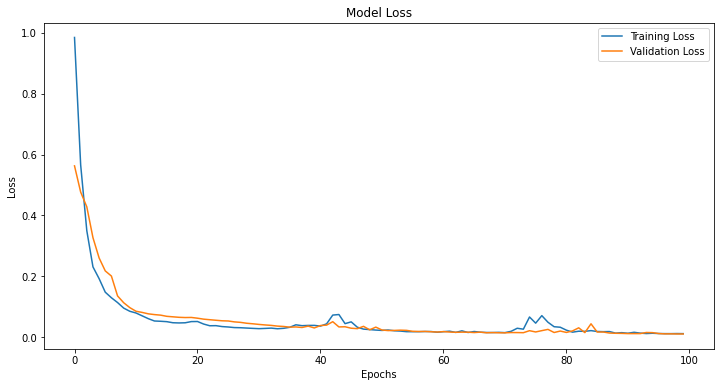

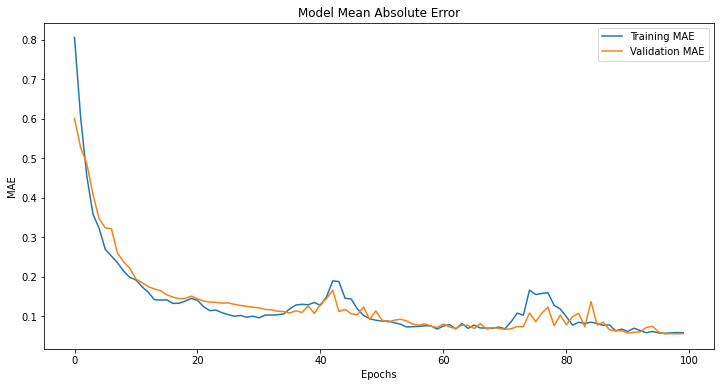

In [5]:
#Part A

import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, RepeatVector, GRU, TimeDistributed
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

X_train = np.load('biomass_X_train.npy')
X_test = np.load('biomass_X_test.npy')
y_train = np.load('biomass_y_train.npy')
y_test = np.load('biomass_y_test.npy')

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = y_train.reshape(-1, 100 * 27)
y_test = y_test.reshape(-1, 100 * 27)
y_train = scaler_y.fit_transform(y_train).reshape(-1, 100, 27)
y_test = scaler_y.transform(y_test).reshape(-1, 100, 27)

model = Sequential([
    Dense(128, activation='relu', input_shape=(28,)),
    RepeatVector(100),
    GRU(128, activation='tanh', return_sequences=True),
    TimeDistributed(Dense(27))
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=1, verbose=0)

test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()



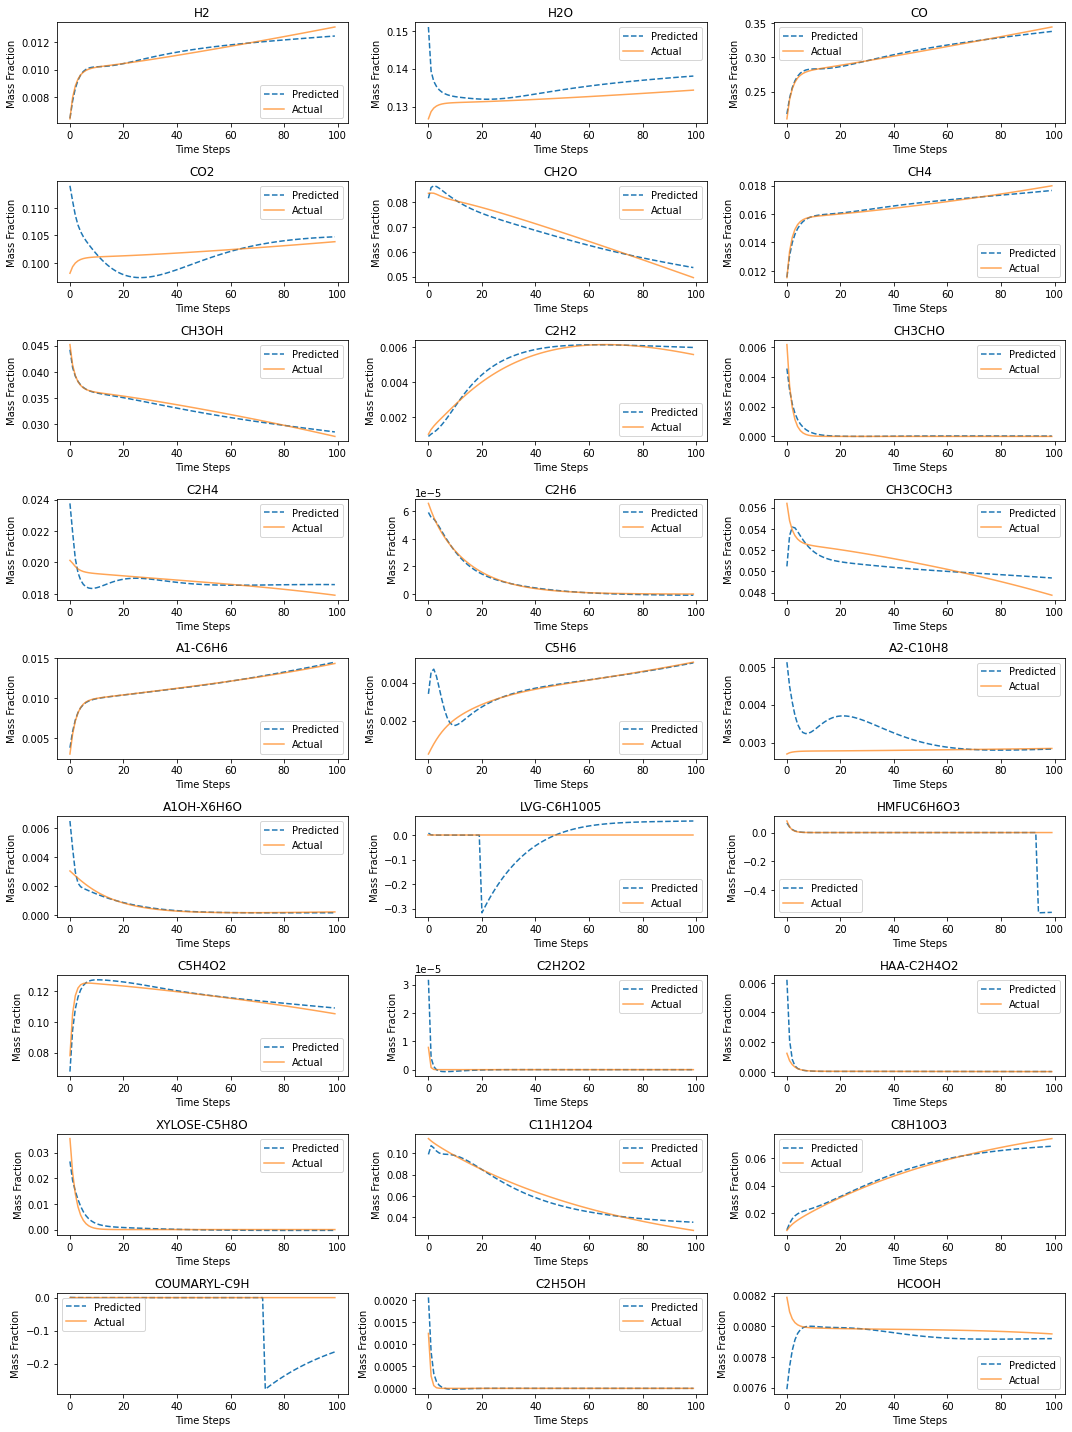

In [8]:
#Part B

#Using vars from part A

initial_condition = X_test[0].reshape(1, -1)

predicted_mass_fractions = model.predict(initial_condition)

predicted_mass_fractions_unscaled = scaler_y.inverse_transform(
    predicted_mass_fractions.reshape(-1)
).reshape(100, 27)

actual_mass_fractions_unscaled = scaler_y.inverse_transform(
    y_test[0].reshape(-1)
).reshape(100, 27)

species_names = [
    "H2", "H2O", "CO", "CO2", "CH2O", "CH4", "CH3OH", "C2H2", "CH3CHO",
    "C2H4", "C2H6", "CH3COCH3", "A1-C6H6", "C5H6", "A2-C10H8", "A1OH-X6H6O",
    "LVG-C6H1005", "HMFUC6H6O3", "C5H4O2", "C2H2O2", "HAA-C2H4O2",
    "XYLOSE-C5H8O", "C11H12O4", "C8H10O3", "COUMARYL-C9H", "C2H5OH", "HCOOH"
]

fig, axes = plt.subplots(9, 3, figsize=(15, 20))
axes = axes.ravel()

for i in range(27):
    axes[i].plot(predicted_mass_fractions_unscaled[:, i], label="Predicted", linestyle="--")
    axes[i].plot(actual_mass_fractions_unscaled[:, i], label="Actual", alpha=0.7)
    axes[i].set_title(species_names[i])
    axes[i].set_xlabel("Time Steps")
    axes[i].set_ylabel("Mass Fraction")
    axes[i].legend()

plt.tight_layout()
plt.show()

